In [1]:
import numpy as np
import pandas as pd

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")
from sklearn.linear_model import Ridge
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neural_network import MLPRegressor

import warnings
from scipy.linalg import LinAlgWarning
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

import pyro
import pyro.distributions as dist
import torch
import pyro.infer.mcmc as mcmc

First, we define a get_training_data function that extracts data from our cleaned data source stadium_county_df 
that we obtained in our reproduction file Synth_Control_Paper. 

In [2]:
#Stadium data for obtaining training data 
stadium_county_df = pd.read_csv('Cleaned_stadium_data.csv')


#Grouped data for running Bayesian SC
grouped_df = pd.read_csv('Grouped_df.csv')

county_covid = pd.read_csv('County_Covid_Data.csv')

county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]
county_covid['county'] = county_covid['county'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Ignore LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [4]:
#Below function gets training X and training Y data for applying Bayesian Model 
def get_training_data(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):

    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.

    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s


    intervention_date = pd.to_datetime(intervention_date)


    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
            
    #print(stadium_county_df)
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0]#.copy()
    #synthetic_counties = list(synthetic_counties)
    synthetic_counties = eval(synthetic_counties)
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)
    
    #print(synthetic_counties)

    #Find Dataframe of X and Y data
    #Special case where 
    
    
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    test_pivot = total_pivot.loc[total_pivot['date'] >= intervention_date]
    
    test_pivot = test_pivot.drop(['date'], axis=1)
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    test_X = test_pivot.loc[:, ~test_pivot.columns.isin(['Stadium_County'])]
    test_Y = test_pivot['Stadium_County']
    
    

    return X_train, Y_train, test_X, test_Y, total_dates

x_train, y_train, x_test, y_test, dates = get_training_data('Cincinnati',["Hamilton"] ,["OH"], ['10/04/2020'], True, 0)




Here, we create the Model structures, all using Pyro to sample. 

We incorporate a mask input to use for our population predictive checks. 

The 3 models are Bayesian PCA, Poisson Factorization, and Poisson Gamma Dynamical Systems

In [5]:
def bayesian_pca(data, latent_dim, mask): #Pass in mask directly into the model 
    # Define model parameters
    n, p = data.shape
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mu = torch.zeros(p)
    covariance = sigma * torch.eye(p)
    
    Z_mean = pyro.param("Z_mean", torch.zeros(n, latent_dim))
    Z_cov = pyro.param("Z_cov", torch.eye(latent_dim))


    W_mean = pyro.param("W_mean", torch.zeros(latent_dim, p))
    W_cov = pyro.param("W_cov", torch.eye(p))
    
    
    Z_mean.data = torch.zeros(n, latent_dim)
    Z_cov.data = torch.eye(latent_dim)
    W_mean.data = torch.zeros(latent_dim, p)
    W_cov.data = torch.eye(p)

    Z_nl = pyro.sample("Z", dist.MultivariateNormal(Z_mean, Z_cov))
    W_lp = pyro.sample("W", dist.MultivariateNormal(W_mean, W_cov))
    
    mean = Z_nl @ W_lp

    #Implement mask on our data to avoid masked probabilities. 

    X = pyro.sample("X", dist.Normal(mean, sigma).mask(mask), obs=data)
    
    return X

def poisson_factorization(data, latent_dim, mask):
    # Define model parameters
    n, p = data.shape
    
    #Construct samples of F, G, and X. X is assumed to be poisson distribution of F * G
    
#     alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
#     beta = pyro.sample("beta", dist.Gamma(1., 1.))
    F = pyro.sample("F", dist.Gamma(1, 1).expand([n, latent_dim]))
    G = pyro.sample("G", dist.Gamma(1, 1).expand([latent_dim, p]))
    

    #use our mask to mask data

    #Implement mask on our data to avoid those probabilities. 
#     with pyro.poutine.mask(mask=mask):
#         X = pyro.sample("X", dist.Poisson(F @ G), obs=data)x
    X = pyro.sample("X", dist.Poisson(F @ G).mask(mask), obs=data)
    
    return X

def poisson_gamma_dynamical_system(data, latent_dim, mask=None):
    # Define model parameters
    n, p = data.shape
    time_steps = n
    G_matrix = []

    # Priors for latent states
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    beta = pyro.sample("beta", dist.Gamma(1., 1.))
    
    g_previous = pyro.sample("g_0", dist.Gamma(alpha, beta).expand([latent_dim]))

    #F should have shape latent * p 
    F_matrix = pyro.sample("F", dist.Gamma(1., 1.).expand([latent_dim, p]))
    
    G_matrix.append(g_previous)
    
    
    #K by K transition matrix
    concentration = torch.tensor([1] * latent_dim, dtype=torch.float)
    

    transition_matrix = pyro.sample("transition_matrix", dist.Dirichlet(concentration).expand([latent_dim]))#K by K matrix, Dirichlet Prior

    # Transition dynamics for the latent states
    
    # Transition dynamics for the latent states
    for t in pyro.markov(range(1, time_steps)):
        alpha_t = transition_matrix @ g_previous.T # previous
        
        g_t = pyro.sample(f"g_{t}", dist.Gamma(alpha_t, beta))
        G_matrix.append(g_t)

        # Update the previous state
        g_previous = g_t

    G_matrix = torch.stack(G_matrix, dim=0)
    
    if mask is None:
        mask = torch.ones(data.shape).bool()
    #Apply masking if necessary 
    X = pyro.sample("X", dist.Poisson(G_matrix @ F_matrix).mask(mask), obs=data)
    
    return X

Now, we define the MCMC functions we use to sample from the posterior distribution for posterior inference for each
of our three models. We use the NUTS kernel and pyro's built in Monte Carlo Markov Chain process

In [59]:
def bayesian_pca_mcmc(data, latent_dim, warmup_steps, num_samples, mask_type = 'None'):
    #data = torch.tensor(data.values)
    pyro.clear_param_store()   
    kernel = mcmc.NUTS(bayesian_pca)
    mcmc_run = mcmc.MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)

    N, P = data.shape
    
    
    if mask_type == "Random":
        mask_rows = torch.randperm(N)[:20]
        mask_cols = torch.randperm(P)[:5]

        mask = torch.ones(N,P)

        for i in mask_rows:
            for j in mask_cols:
                mask[i,j] = 0

        mask = mask.bool() #Random column and rows mask
        
    elif mask_type == "End":

        #TEST END BLOCK MASK
        end_block_mask = torch.ones(N,P)
        end_block_mask[-30:, -3:] = 0
        mask = end_block_mask.bool()
        
    elif mask_type == "None":
        mask = torch.ones(N,P).bool()
    else:
        print("Invalid Mask")
        return


    #Apply MCMC to our data
    mcmc_run.run(data, latent_dim, mask)

    pyro.clear_param_store()
    #print(dummy_train)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract W, sigma, and Z samples
    W_samples = posterior_samples["W"]
    sigma_samples = posterior_samples["sigma"]
    Z_samples = posterior_samples["Z"]
    
    return W_samples, sigma_samples, Z_samples

def poisson_mcmc(training_data, latent_dim, warmup_steps, samples, mask_type="Random"): #Default masking type is Random
    #Runs MCMC on the poisson model, returns F and G Samples

    #training_data = torch.tensor(training_data.values)
    #Is our latent dimension here also deterined as a hyperparameter? 
    model = poisson_factorization


    #Create mask for training/testing purposes
    N, P = training_data.shape
    
    if mask_type == "Random":
        mask_rows = torch.randperm(N)[:20]
        mask_cols = torch.randperm(P)[:5]

        mask = torch.ones(N,P)

        for i in mask_rows:
            for j in mask_cols:
                mask[i,j] = 0

        mask = mask.bool() #Random column and rows mask
        
    elif mask_type == "End":

        #TEST END BLOCK MASK
        end_block_mask = torch.ones(N,P)
        end_block_mask[-30:, -3:] = 0
        mask = end_block_mask.bool()
        
    elif mask_type == "None":
        mask = torch.ones(N,P).bool()
    else:
        print("Invalid Mask")
        return

    # Run MCMC
    kernel = mcmc.NUTS(model)
    mcmc_run = mcmc.MCMC(kernel, num_samples=samples, warmup_steps=warmup_steps)

    #Run MCMC process on our data with given Latent dimension
    mcmc_run.run(training_data, latent_dim, mask)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract F, G, lambda_f, and lambda_g samples
    F_samples = posterior_samples["F"]
    G_samples = posterior_samples["G"]
    
    return F_samples, G_samples
    
    
def poisson_gamma_mcmc(training_data, latent_dim, warmup_steps, samples, mask_type = None):
    
    model = poisson_gamma_dynamical_system
    
    N,P = training_data.shape
    
    kernel = mcmc.NUTS(model)
    
    pyro.clear_param_store()
    mcmc_run = mcmc.MCMC(kernel, num_samples = samples, warmup_steps = warmup_steps)
    
    mcmc_run.run(training_data, latent_dim)
    
    posterior_samples = mcmc_run.get_samples()
    
    F_samples = posterior_samples["F"]
    
    
    G_samples = [posterior_samples[f"g_{t}"].numpy() for t in range(N)]
    G_samples = np.stack(G_samples, axis=1)
        
    return G_samples, F_samples

Now, we define our posterior check process, with both a posterior predictive check and a population predictive check. 

The population predictive check compares the likelihood of the current data samples of the produced probability distribution
to the likelihood of simulated samples from the produced probability distribution. 


The posterior predictive check is more robust, and rather masks out a portion of the data during the training process to be held out
for testing. For this masked part, we compare likelihood of the data samples that weren't used in training to likelihoods produced from 
simulating samples from the posterior probability distribution. 

We use 2 kinds of mask, a random mask, that creates a random combination of counties and timestamps to mask out, as well as
an end block mask, that masks out a lower rectangle, simulating holding out data for the last few time periods for a certain amount of 
counties, which better fits our task in time inference, as it is using past data to predict future data in a sense.

In [61]:
#General Population Predictive Check function

def population_predictive_check(reconstructed_mean, mask, data, model, variance=None): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []

    
    if variance is not None: #PCA
        for mean, var in zip(reconstructed_mean, variance):
            testing_mean = torch.tensor(mean[mask])
            sample_dist = dist.Normal(testing_mean, var)
            
            #Only have prediction on selected mask_rows and mask_cols
            y_pred  = sample_dist.sample()

            #Calculate the likelihood given this sample
            y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

            #Now, we want to calculate the likelihood of the actual data. 
            data_test = torch.tensor(data[mask])

            test_prob = sample_dist.log_prob(data_test).sum()

            log_prob.append(-1 * y_pred_likelihood) 
            test_prob_list.append(-1 * test_prob)

    else: #Poisson
        for mean in reconstructed_mean:
            testing_mean = torch.tensor(mean[mask])
            sample_dist = dist.Poisson(testing_mean)

            #Only have prediction on selected mask_rows and mask_cols
            y_pred  = sample_dist.sample()

            #Calculate the likelihood given this sample
            y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

            #Now, we want to calculate the likelihood of the actual data. 
            data_test = torch.tensor(data[mask])

            test_prob = sample_dist.log_prob(data_test).sum()

            log_prob.append(-1 * y_pred_likelihood) 
            test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    
    print(log_prob[:5])
    print(test_prob_list[:5])
    
    return percent_likelihood
    
    
#General Posterior Predictive Check Method(No Mask)

def posterior_predictive_check(reconstructed_mean, data, model, variance=None): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []

    if variance is not None: #PCA
        for mean, var in zip(reconstructed_mean, variance):
            sample_dist = dist.Normal(mean, var)
            
            #Only have prediction on selected mask_rows and mask_cols
            y_pred = sample_dist.sample()

            #Calculate the likelihood given this sample
            y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

            #Now, we want to calculate the likelihood of the actual data. 
            data_test = torch.tensor(data)

            test_prob = sample_dist.log_prob(data_test).sum()

            log_prob.append(-1 * y_pred_likelihood) 
            test_prob_list.append(-1 * test_prob)

    else: #Poisson
        for mean in reconstructed_mean:
            sample_dist = dist.Poisson(mean)
            

        #Only have prediction on selected mask_rows and mask_cols
        y_pred = sample_dist.sample()

        #Calculate the likelihood given this sample
        y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

        #Now, we want to calculate the likelihood of the actual data. 
        data_test = torch.tensor(data)

        test_prob = sample_dist.log_prob(data_test).sum()

        log_prob.append(-1 * y_pred_likelihood) 
        test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    
    print(log_prob[:5])
    print(test_prob_list[:5])
    
    return percent_likelihood
    

Finally, when our model does pass the predictive check, we implement the actual synthetic control process. 

In this process, we take the trained samples that is indexed by counties (F_samples for Poisson, W_samples for PCA) ,
and perform a large scale regression using these samples. 

We regress the post intervention time stamp results on our X, which is a concatenation of the Trained samples and the 
actual data for the donor counties, and a A column that represents whether or not the county opened to fans that is 1 for the stadium county. 

To produce the synthetic control coutnerfactuals, we change the A from 1 to 0 for the stadium county, and then reconstruct 
the data with the new regression weights. 

In [24]:
from sklearn.linear_model import LinearRegression

def Synthetic_control(W_samples, donor_train, stadium_train, donor_test, stadium_test, dates, team, RBSC, regression_type = 'Ridge', save_fig = False, show_graph = False):
    #W_Samples should be size latent_dim * p
    
    #Z_samples size n * latent_dim
    #Donor_data should be size n*p 
    
    #Stadium_data should be size n*1
    
    #Our Y should be donor_test and stadium_test, so size should be post_intervention_t * p+1
    #Stadium_test is our Y, shape p by T
    
    synthetic_control_paths = []
    pre_intervention_days, counties = donor_train.shape
    post_intervention_days, counties = donor_test.shape

    latent_dim, w_counties = W_samples[0].shape
    
    #Store results for different synthetic control regressions, as we iterate through W_samples
    counterfactual_outcomes_deconfound = []
    time_step_outcomes = []
    
    for W_sample in W_samples: 
    
        #Run Regression with latent_p W_sample on Y_it, for each timestep t post intervention. 
        
        
        #Add [1] if it is intervention
        
        A = torch.zeros(w_counties)
        A[-1] = 1
        A = A.view(1, w_counties)

        x_regressors = torch.cat((W_sample, A), dim=0).transpose(0,1)
        
        assert x_regressors.shape == (w_counties, latent_dim + 1)

        #For Yit ~ Ai + Yi(-m) + … + Yi(-1), ,we need stadium data pre intervention, which is just stadium train

        #We want to fit donor_test and stadium_test together in one regression
        stadium_test = stadium_test.view(-1, 1)

        Y = torch.cat((donor_test, stadium_test), dim = 1)
        
        
        assert Y.shape == (post_intervention_days,  w_counties)
        
        #Ridge regression with alpha = 0.001 Works better
        #Try Ridge, Lasso, MLP Regression ,with Cross Validation to find best value. 
        
        #Parameters for GridsearchCV for Lasso and Ridge
        parameters = {"alpha": [0, 1e-4,1e-3, 1e-2]}
        if regression_type == 'Ridge':
            reg = linear_model.Ridge()
            clf = GridSearchCV(reg, parameters, scoring='r2', cv=5)
        elif regression_type == 'MLP': 
            clf = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
        elif regression_type == 'Lasso':
            reg = linear_model.Lasso()
            parameters = {'alpha': [0.01]}
            #Right now 0.01 working best for lasso
            clf = GridSearchCV(reg, parameters, scoring = 'r2', cv=5)
            
        deconfound_lin_reg = clf.fit(x_regressors, Y.transpose(0,1))
        deconfound_lin_reg = clf.best_estimator_
        


        
        counterfactual_x = x_regressors
        counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.
        
        if regression_type == 'MLP':
            counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
        elif regression_type in ['Ridge', 'Lasso']:
            coefficients = torch.tensor(deconfound_lin_reg.coef_)
        
            assert coefficients.shape[1] == latent_dim + 1
            assert coefficients.shape[0] == post_intervention_days


            #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
            #stadium county .

            counterfactual_outcome = counterfactual_x @ torch.tensor(coefficients).transpose(0,1)
        
        assert counterfactual_outcome.shape == Y.transpose(0,1).shape
        
        counterfactual_outcomes_deconfound.append(counterfactual_outcome)
        
        
        stadium_train = stadium_train.view(-1,1)

        
    
    if regression_type in ['Ridge', 'Lasso']:
        stadium_cf_deconfound = [counterfactuals[-1, :].numpy() for counterfactuals in counterfactual_outcomes_deconfound]
    else:
        stadium_cf_deconfound = [counterfactuals[-1, :] for counterfactuals in counterfactual_outcomes_deconfound]
    
    
    percentiles_5 = np.percentile(stadium_cf_deconfound, 5, axis=0)
    percentiles_95 = np.percentile(stadium_cf_deconfound, 95, axis=0)
    
    
    median_values = np.median(stadium_cf_deconfound, axis=0)
    post_dates = dates[-post_intervention_days:]
    plt.fill_between(post_dates, percentiles_5, percentiles_95, color='gray', alpha=0.3, label='5th-95th Percentile Range')
    pre_dates = dates[:pre_intervention_days]
    plt.plot(post_dates, median_values, label='Bayesian Synthetic Control Median Values ' + str(regression_type) + ' '+ str(team))
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='major')
    
    plt.plot(post_dates, stadium_test, label = 'Stadium Data Postintervention')
    plt.plot(pre_dates, stadium_train, label = 'Stadium Data Pre-intervention')
    plt.axvline(x=dates[pre_intervention_days], color='grey')

    
    plt.plot(dates, RBSC, label = 'Robust Synthetic Control')
    plt.title('Synthetic Control ' + str(team) + " with number of latents " + str(W_samples[0].shape[0]) + " and counties " + str(W_samples[0].shape[1]) +" and number of samples " + str(len(W_samples)))
    plt.legend()
    #Save plot figure
    if save_fig:
        plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
        plt.tight_layout() 
        folder = 'figures'
        file_name = f'{team}_g_samples.npy'

        save_name = f'{team}_plot.png'
        save_path = os.path.join(folder, save_name)
        plt.savefig(save_path)
        
    if show_plot:

        plt.show()

    
    return median_values


In [57]:
#Create dictionary for latent space dimensions for each team. 
latent_dim_dict = {'Arizona': 5, 'Atlanta':7 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinxnati':13, 'Cleveland':14, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':10, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 12, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':4}


Warmup:   3%|▎         | 30/1000 [00:11, 21.32it/s, step size=3.47e-06, acc. prob=0.754]

Sample: 100%|██████████| 2000/2000 [7:46:20, 13.99s/it, step size=1.41e-04, acc. prob=0.954]  


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(45949.2900, dtype=torch.float64), tensor(45972.8945, dtype=torch.float64), tensor(45990.4597, dtype=torch.float64), tensor(45960.2062, dtype=torch.float64), tensor(46061.3772, dtype=torch.float64)]
[tensor(53632749.7276, dtype=torch.float64), tensor(53617599.3214, dtype=torch.float64), tensor(53578834.0564, dtype=torch.float64), tensor(53575905.1031, dtype=torch.float64), tensor(53526010.9473, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(46254.1366, dtype=torch.float64), tensor(46257.4951, dtype=torch.float64), tensor(46374.0969, dtype=torch.float64), tensor(46471.5144, dtype=torch.float64), tensor(46425.4511, dtype=torch.float64)]
[tensor(55307607.5062, dtype=torch.float64), tensor(55289910.7523, dtype=torch.float64), tensor(55244719.5715, dtype=torch.float64), tensor(55241842.8002, dtype=torch.float64), tensor(55183948.9474, dtype=torch.float64)]


NameError: name 'show_plot' is not defined

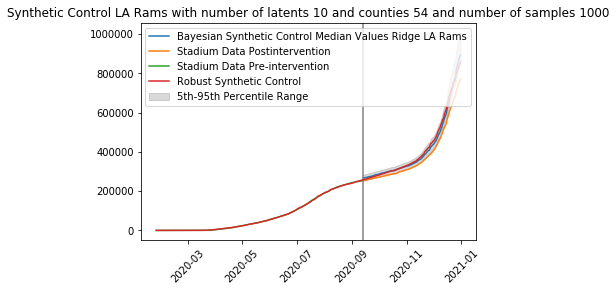

In [58]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])
import ast

def bayesian_SC_graph(team_county_data):
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        count += 1
        date = ast.literal_eval(date)
        #team = ast.literal_eval(team)
        county = ast.literal_eval(county)
        state = ast.literal_eval(state)
        if team in ['LA Rams']:  #Ignore Arizona
            #x are donors, y are stadiums, train is pre-intervention, test is post intervention

        
            x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

            x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)


            #Combine Donor and Stadium in our traning data
            synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)

            #Produce Confounder variable to use in our regression

            #Run Poisson Factorization Model

            latent_dimension = latent_dim_dict[team]
            

            #Can edit masking below for type of check. 
            f_samples, g_samples = poisson_mcmc(synthetic_control_training, latent_dimension, 1000, 1000, "None")

            np.save(f'{team}_g_samples.npy', g_samples.numpy())
            np.save(f'{team}_f_samples.npy', f_samples.numpy())
            synthetic_control_training = synthetic_control_training.clamp(min=0)
            
            
            N,P = synthetic_control_training.shape
            end_block_mask = torch.ones(N,P)
            end_block_mask[-30:, -3:] = 0 #The mask size can be edited
            end_block_mask = end_block_mask.bool()

            #Population check is with mask 
            population_check = population_predictive_check(f_samples @ g_samples, end_block_mask, synthetic_control_training.round().to(torch.int64), 'Poisson')

            
            #Posterior check without mask 
            poisson_p_value = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')

            
            #Keep at 0 for testing purposes now. 
            poisson_posterior_check = poisson_p_value >= 0
            
            RBSC_results = np.load(f'RBSC_Replications/{team}_RBSC.npy')
            
            if poisson_posterior_check:

                deconfounders_ridge = Synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge')
                deconfounders_lasso = Synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Lasso')

            else:
                w_samples, sigma_samples, z_samples = bayesian_pca_mcmc(synthetic_control_training, 10, 1000, 800)

                pca_p_value = posterior_predictive_check(z_samples@w_samples, synthetic_control_training, 'PCA', variance=sigma_samples[0])


                #Keep at 0 for testing purposes now
                pca_posterior_check = pca_p_value>=0

                if pca_posterior_check:
                    deconfounders = Synthetic_control(w_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge')



    return

bayesian_SC_graph(zipped_input)
        

NameError: name 'show_plot' is not defined

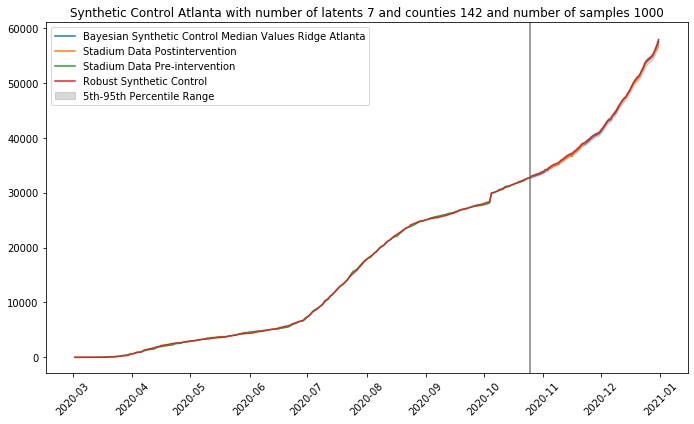

In [25]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

def bayesian_SC_graph_pre_loaded(team_county_data, calculate_ATT = False): #Difference is this function takes from pre-trained samples.
#We want to calculate ATT. 

    ATT_Bayesian_list = []
    ATT_RBSC_list = []
    
    for i, (team, county, state, date) in enumerate(team_county_data):
        
        date = ast.literal_eval(date)
        #team = ast.literal_eval(team)
        county = ast.literal_eval(county)
        state = ast.literal_eval(state)
        #if team in ['Cincinnati', 'Cleveland', 'Carolina', 'Atlanta', 'Denver', 'Kansas City', 'Minnesota', 'Philadelphia', 'Seattle', 'San Francisco', 'Tennessee']:
        if team == 'Atlanta': #Arizona data not included
            
            
            #f_samples = torch.from_numpy(np.load(f'{team}_f_samples.npy')) F samples used for posterior check
            g_samples = torch.from_numpy(np.load(f'{team}_g_samples.npy'))
            #f_samples = torch.from_numpy(np.load(f'Trained_Samples/{team}_f_samples.npy'))

            x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

            x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)
            synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)
            synthetic_control_training = synthetic_control_training.clamp(min=0)

            synthetic_control_training = synthetic_control_training.clamp(min=0)
            RBSC_results = np.load(f'RBSC_Replications/{team}_RBSC.npy')

            deconfounders_ridge = Synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge', save_fig = True)
            #deconfounders_lasso = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Lasso')
            
            #post_check = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')
            
            if calculate_ATT:
                ATT_RBSC_list.append(RBSC_results)
                ATT_Bayesian_list.append(deconfounders_ridge)
                
#             posterior_check = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')
#             print(posterior_check)
    
#     min_len = min(len(lst) for lst in ATT_Bayesian_list)
#     truncated_lists = [lst[:min_len] for lst in ATT_Bayesian_list]
#     Bayesian_transposed= np.array(truncated_lists).T
#     ATT_Bayesian = np.mean(Bayesian_transposed, axis=0)
    
#     min_len = min(len(lst) for lst in ATT_bayesian_list)
#     truncated_lists = [lst[:min_len] for lst in ATT_Bayesian_list]
#     RBSC_transposed= np.array(truncated_lists).T
#     ATT_RBSC = np.mean(Bayesian_transposed, axis=0)
    
    return 1,2# ATT_Bayesian, ATT_RBSC
            
ATT_Bayesian, Att_RBSC = bayesian_SC_graph_pre_loaded(zipped_input, False)

In [66]:
#### DRAFT FOR MASKED DATA

zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])


def bayesian_SC_masked(team_county_data):
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        count += 1
        date = ast.literal_eval(date)
        #team = ast.literal_eval(team)
        county = ast.literal_eval(county)
        state = ast.literal_eval(state)

        #if team in ['Chicago','Tennessee', 'Detroit', 'Indianapolis']:  #Ignore Arizona
        if count > 20:  #Ignore Arizona
            #x are donors, y are stadiums, train is pre-intervention, test is post intervention

            x_train, y_train, x_test, y_test, dates = get_training_data(team,county ,state, date, True, 0)

            x_train, y_train, x_test, y_test = torch.tensor(x_train.values),torch.tensor(y_train.values), torch.tensor(x_test.values), torch.tensor(y_test.values)

            print(team)
            #Combine Donor and Stadium in our traning data
            synthetic_control_training = torch.cat((x_train, torch.unsqueeze(y_train,1)), dim=1)

            latent_dimension = latent_dim_dict[team]
            


            num_samples = torch.from_numpy(np.load(f'Trained_Samples/{team}_g_samples.npy')).shape[0]
            
            print("Number samples is" + str(num_samples))
            
            
            f_samples, g_samples = poisson_mcmc(synthetic_control_training, latent_dimension, num_samples, num_samples, "End")

            np.save(f'Masked_Poisson_Samples/{team}_g_samples.npy', g_samples.numpy())
            np.save(f'Masked_Poisson_Samples/{team}_f_samples.npy', f_samples.numpy())
            synthetic_control_training = synthetic_control_training.clamp(min=0)
            
            
            N,P = synthetic_control_training.shape
            end_block_mask = torch.ones(N,P)
            end_block_mask[-30:, -3:] = 0 #The mask size can be edited
            end_block_mask = end_block_mask.bool()

            #Population check is with mask 
            population_check = population_predictive_check(f_samples @ g_samples, end_block_mask, synthetic_control_training.round().to(torch.int64), 'Poisson')

            
            #Posterior check without mask 
            poisson_p_value = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')

            
            #Keep at 0 for testing purposes now. 
            poisson_posterior_check = poisson_p_value >= 0
            
            RBSC_results = np.load(f'RBSC_Replications/{team}_RBSC.npy')
            
            w_samples, sigma_samples, z_samples = bayesian_pca_mcmc(synthetic_control_training, latent_dimension, num_samples, num_samples, 'End')

            population_check = population_predictive_check(z_samples@w_samples, end_block_mask, synthetic_control_training, 'PCA', variance=sigma_samples)
            
            pca_p_value = posterior_predictive_check(z_samples@w_samples, synthetic_control_training, 'PCA', variance=sigma_samples)

            np.save(f'Masked_PPCA_Samples/{team}_g_samples.npy', g_samples.numpy())
            np.save(f'Masked_PPCA_Samples/{team}_f_samples.npy', f_samples.numpy())
            
            
            
            
            
            
            


#             f_samples, g_samples = poisson_mcmc(synthetic_control_training, latent_dimension, 500,500, "None")

#             np.save(f'{team}_g_samples_sf.npy', g_samples.numpy())
#             np.save(f'{team}_f_samples_sf.npy', f_samples.numpy())
#             synthetic_control_training = synthetic_control_training.clamp(min=0)
            
            
#             N,P = synthetic_control_training.shape
#             end_block_mask = torch.ones(N,P)
#             end_block_mask[-30:, -3:] = 0 #The mask size can be edited
#             end_block_mask = end_block_mask.bool()

#             population_check = population_predictive_check(f_samples @ g_samples, end_block_mask, synthetic_control_training.round().to(torch.int64), 'Poisson')

        
#             poisson_p_value = posterior_predictive_check(f_samples @ g_samples, synthetic_control_training.round().to(torch.int64),'Poisson')

#             poisson_posterior_check = poisson_p_value >= 0



#             if poisson_posterior_check:
#                 #Keep the g_samples

#                 deconfounders_ridge = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge', save_fig = False, show_plot = True)
#                 deconfounders_lasso = Poisson_synthetic_control(g_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Lasso', save_fig = False, show_plot = True)

#                 #Find results for robust synthetic control

#             else: #Run Bayesian PCA
#                 w_samples, sigma_samples, z_samples = bayesian_pca_mcmc(synthetic_control_training, latent_dimension, 1000, 800, "None")

#                 pca_p_value = posterior_predictive_check(z_samples@w_samples, synthetic_control_training, 'PCA', variance=sigma_samples[0])


#                 #Keep at 0 for testing purposes now
#                 pca_posterior_check = pca_p_value>=0

#                 if pca_posterior_check:
#                     deconfounders = Synthetic_control(w_samples, x_train, y_train, x_test, y_test, dates, team, RBSC_results, regression_type='Ridge')

                
                
    return 



bayesian_SC_masked(zipped_input)
        

Warmup:   0%|          | 4/1000 [00:00, 24.78it/s, step size=9.78e-04, acc. prob=0.417]

Minnesota
Number samples is500


Warmup:   0%|          | 0/1000 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is0.96
[tensor(46347.3436, dtype=torch.float64), tensor(46054.8372, dtype=torch.float64), tensor(46168.9436, dtype=torch.float64), tensor(46075.1805, dtype=torch.float64), tensor(46203.6698, dtype=torch.float64)]
[tensor(46006.3529, dtype=torch.float64), tensor(46033.0838, dtype=torch.float64), tensor(46034.0538, dtype=torch.float64), tensor(46042.3704, dtype=torch.float64), tensor(46049.0442, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(46610.4144, dtype=torch.float64)]
[tensor(46713.5183, dtype=torch.float64)]


Sample: 100%|██████████| 1000/1000 [47:27,  2.85s/it, step size=7.36e-04, acc. prob=0.891]


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(59396.9046, dtype=torch.float64), tensor(59298.2183, dtype=torch.float64), tensor(59419.9980, dtype=torch.float64), tensor(59478.7516, dtype=torch.float64), tensor(59448.4961, dtype=torch.float64)]
[tensor(80827.3139, dtype=torch.float64), tensor(80804.9615, dtype=torch.float64), tensor(80743.2348, dtype=torch.float64), tensor(80727.0913, dtype=torch.float64), tensor(80637.3004, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(59703.4891, dtype=torch.float64), tensor(59660.8061, dtype=torch.float64), tensor(59721.7275, dtype=torch.float64), tensor(59513.4464, dtype=torch.float64), tensor(59707.8666, dtype=torch.float64)]
[tensor(99509.3568, dtype=torch.float64), tensor(99599.9293, dtype=torch.float64), tensor(99236.8921, dtype=torch.float64), tensor(99405.6864, dtype=torch.float64), tensor(97918.9845, dtype=torch.float64)]


Warmup:   0%|          | 4/2800 [00:00, 34.92it/s, step size=1.56e-05, acc. prob=0.540]

NY Giants
Number samples is1400


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(15441.1364, dtype=torch.float64), tensor(15393.1937, dtype=torch.float64), tensor(15427.5898, dtype=torch.float64), tensor(15335.7730, dtype=torch.float64), tensor(15385.5612, dtype=torch.float64)]
[tensor(22863.1886, dtype=torch.float64), tensor(22850.8002, dtype=torch.float64), tensor(22825.7621, dtype=torch.float64), tensor(22830.7437, dtype=torch.float64), tensor(22715.7207, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(15873.5812, dtype=torch.float64)]
[tensor(17710.0070, dtype=torch.float64)]


Sample: 100%|██████████| 2800/2800 [3:04:05,  3.94s/it, step size=1.10e-10, acc. prob=0.815]


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(11262.4431, dtype=torch.float64), tensor(11228.7930, dtype=torch.float64), tensor(11236.2068, dtype=torch.float64), tensor(11305.0681, dtype=torch.float64), tensor(11192.9070, dtype=torch.float64)]
[tensor(1.0615e+09, dtype=torch.float64), tensor(1.0615e+09, dtype=torch.float64), tensor(1.0615e+09, dtype=torch.float64), tensor(1.0615e+09, dtype=torch.float64), tensor(1.0615e+09, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(11518.1925, dtype=torch.float64), tensor(11559.0372, dtype=torch.float64), tensor(11568.2443, dtype=torch.float64), tensor(11539.4775, dtype=torch.float64), tensor(11530.0796, dtype=torch.float64)]
[tensor(1.1738e+09, dtype=torch.float64), tensor(1.1738e+09, dtype=torch.float64), tensor(1.1738e+09, dtype=torch.float64), tensor(1.1738e+09, dtype=torch.float64), tensor(1.1738e+09, dtype=torch.float64)]


Warmup:   0%|          | 4/2800 [00:00, 32.72it/s, step size=4.89e-04, acc. prob=0.417]

NY Jets
Number samples is1400


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is0.9321428571428572
[tensor(15340.9072, dtype=torch.float64), tensor(15402.5109, dtype=torch.float64), tensor(15390.6915, dtype=torch.float64), tensor(15290.3693, dtype=torch.float64), tensor(15447.5720, dtype=torch.float64)]
[tensor(15217.4277, dtype=torch.float64), tensor(15282.7964, dtype=torch.float64), tensor(15210.1697, dtype=torch.float64), tensor(15269.0125, dtype=torch.float64), tensor(15240.8412, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(15818.9532, dtype=torch.float64)]
[tensor(15933.8060, dtype=torch.float64)]


Sample: 100%|██████████| 2800/2800 [3:13:44,  4.15s/it, step size=8.30e-11, acc. prob=0.892]


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(11226.9303, dtype=torch.float64), tensor(11204.9400, dtype=torch.float64), tensor(11247.3721, dtype=torch.float64), tensor(11148.4325, dtype=torch.float64), tensor(11207.8432, dtype=torch.float64)]
[tensor(1.0446e+09, dtype=torch.float64), tensor(1.0446e+09, dtype=torch.float64), tensor(1.0446e+09, dtype=torch.float64), tensor(1.0446e+09, dtype=torch.float64), tensor(1.0446e+09, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(11548.5628, dtype=torch.float64), tensor(11576.0131, dtype=torch.float64), tensor(11535.4086, dtype=torch.float64), tensor(11547.4554, dtype=torch.float64), tensor(11617.3484, dtype=torch.float64)]
[tensor(1.1450e+09, dtype=torch.float64), tensor(1.1450e+09, dtype=torch.float64), tensor(1.1450e+09, dtype=torch.float64), tensor(1.1450e+09, dtype=torch.float64), tensor(1.1450e+09, dtype=torch.float64)]


Warmup:   0%|          | 6/2800 [00:00, 58.89it/s, step size=1.58e-04, acc. prob=0.500]

New England
Number samples is1400


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is0.84
[tensor(12327.1345, dtype=torch.float64), tensor(12382.4748, dtype=torch.float64), tensor(12323.2639, dtype=torch.float64), tensor(12399.0497, dtype=torch.float64), tensor(12346.9212, dtype=torch.float64)]
[tensor(12231.0905, dtype=torch.float64), tensor(12177.0042, dtype=torch.float64), tensor(12189.6758, dtype=torch.float64), tensor(12263.8720, dtype=torch.float64), tensor(12227.8982, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(12880.5642, dtype=torch.float64)]
[tensor(13714.0658, dtype=torch.float64)]


Sample: 100%|██████████| 2800/2800 [4:17:47,  5.52s/it, step size=1.98e-05, acc. prob=0.697] 


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(9794.7483, dtype=torch.float64), tensor(9893.1890, dtype=torch.float64), tensor(9873.9804, dtype=torch.float64), tensor(9811.3369, dtype=torch.float64), tensor(9771.5440, dtype=torch.float64)]
[tensor(5.5142e+08, dtype=torch.float64), tensor(5.5142e+08, dtype=torch.float64), tensor(5.5142e+08, dtype=torch.float64), tensor(5.5142e+08, dtype=torch.float64), tensor(5.5142e+08, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(10163.7499, dtype=torch.float64), tensor(10118.8603, dtype=torch.float64), tensor(10213.3424, dtype=torch.float64), tensor(10186.8663, dtype=torch.float64), tensor(10211.5043, dtype=torch.float64)]
[tensor(6.6251e+08, dtype=torch.float64), tensor(6.6251e+08, dtype=torch.float64), tensor(6.6251e+08, dtype=torch.float64), tensor(6.6251e+08, dtype=torch.float64), tensor(6.6251e+08, dtype=torch.float64)]


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

New Orleans
Number samples is1400


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(47386.6260, dtype=torch.float64), tensor(47317.8115, dtype=torch.float64), tensor(47276.2790, dtype=torch.float64), tensor(47381.0895, dtype=torch.float64), tensor(47360.2790, dtype=torch.float64)]
[tensor(44446.8793, dtype=torch.float64), tensor(44400.2072, dtype=torch.float64), tensor(44409.8121, dtype=torch.float64), tensor(44437.6981, dtype=torch.float64), tensor(44390.6840, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(47922.6852, dtype=torch.float64)]
[tensor(45505.2142, dtype=torch.float64)]


Sample: 100%|██████████| 2800/2800 [3:33:34,  4.58s/it, step size=2.78e-04, acc. prob=0.902] 


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(44319.2871, dtype=torch.float64), tensor(44319.6147, dtype=torch.float64), tensor(44102.5106, dtype=torch.float64), tensor(44247.2755, dtype=torch.float64), tensor(44024.1254, dtype=torch.float64)]
[tensor(400483.9809, dtype=torch.float64), tensor(399822.1597, dtype=torch.float64), tensor(396668.2660, dtype=torch.float64), tensor(396156.4043, dtype=torch.float64), tensor(396035.8465, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(44518.0117, dtype=torch.float64), tensor(44513.8797, dtype=torch.float64), tensor(44440.7945, dtype=torch.float64), tensor(44609.6586, dtype=torch.float64), tensor(44594.6449, dtype=torch.float64)]
[tensor(492705.6677, dtype=torch.float64), tensor(492803.3773, dtype=torch.float64), tensor(488707.5990, dtype=torch.float64), tensor(489190.9909, dtype=torch.float64), tensor(489230.8690, dtype=torch.float64)]


Warmup:   0%|          | 4/1800 [00:00, 39.78it/s, step size=4.89e-04, acc. prob=0.417]

Philadelphia
Number samples is900


Warmup:   0%|          | 0/1800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(41907.6546, dtype=torch.float64), tensor(42050.6913, dtype=torch.float64), tensor(42058.1855, dtype=torch.float64), tensor(41884.0436, dtype=torch.float64), tensor(41957.3408, dtype=torch.float64)]
[tensor(38692.4750, dtype=torch.float64), tensor(38735.4617, dtype=torch.float64), tensor(38726.2773, dtype=torch.float64), tensor(38660.4843, dtype=torch.float64), tensor(38710.5763, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(42436.2597, dtype=torch.float64)]
[tensor(40321.5848, dtype=torch.float64)]


Sample: 100%|██████████| 1800/1800 [1:58:25,  3.95s/it, step size=5.11e-06, acc. prob=0.783]


Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(42704.7268, dtype=torch.float64), tensor(42782.8197, dtype=torch.float64), tensor(42558.6042, dtype=torch.float64), tensor(42572.7675, dtype=torch.float64), tensor(42532.0468, dtype=torch.float64)]
[tensor(63127372.8351, dtype=torch.float64), tensor(63127372.8590, dtype=torch.float64), tensor(63127373.1168, dtype=torch.float64), tensor(63127372.9292, dtype=torch.float64), tensor(63127372.9284, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is0.0
[tensor(42848.9615, dtype=torch.float64), tensor(43081.7707, dtype=torch.float64), tensor(42949.4761, dtype=torch.float64), tensor(42824.8791, dtype=torch.float64), tensor(42974.5094, dtype=torch.float64)]
[tensor(2.8483e+08, dtype=torch.float64), tensor(2.8483e+08, dtype=torch.float64), tensor(2.8484e+08, dtype=torch.float64), tensor(2.8484e+08, dtype=torch.float64), tensor(2.8484e+08, dtype=torch.float64)]


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Pittsburgh
Number samples is1400


Warmup:   0%|          | 0/2800 [00:00, ?it/s]

Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(40231.5442, dtype=torch.float64), tensor(40201.4213, dtype=torch.float64), tensor(40310.1713, dtype=torch.float64), tensor(40126.5013, dtype=torch.float64), tensor(40167.6528, dtype=torch.float64)]
[tensor(37002.5613, dtype=torch.float64), tensor(36919.1328, dtype=torch.float64), tensor(36838.1804, dtype=torch.float64), tensor(36844.3016, dtype=torch.float64), tensor(36854.3076, dtype=torch.float64)]
Percentage of Test distribution more likely than Y_Pred is1.0
[tensor(40749.5512, dtype=torch.float64)]
[tensor(38164.6827, dtype=torch.float64)]


Sample:  85%|████████▌ | 2380/2800 [3:16:15,  8.01s/it, step size=7.66e-04, acc. prob=0.904]

KeyboardInterrupt: 